# Gibbs Sampling

This is useful for sampling from complex distribution $-$ multi-dimensional distribution  by component-wise sampling indenpendently. For example, we want to model three parameters, $\theta_{1}$, $\theta_{2}$ and $\theta_{3}$ sequentially as follows.

1. Initialize $\theta_{1}^{0}$, $\theta_{2}^{0}$ and $\theta_{3}^{0}$ as some value
2. for each iteration $i$:
 - create a new value $\theta_{1}^{i}$ conditioned on values $\theta_{2}^{i-1}$ and $\theta_{3}^{i-1}$
 - create a new value $\theta_{2}^{i}$ conditioned on values $\theta_{1}^{i}$ and $\theta_{3}^{i-1}$
 - create a new value $\theta_{3}^{i}$ conditioned on values $\theta_{1}^{i}$ and $\theta_{2}^{i}$

![example](https://donghwa-kim.github.io/picture/gibbs_seque.png)

# LDA with Gibbs Sampling

There is an approach to estimate the posterior distrubution over assigning words to topics, namely, $\theta$ and $\phi$ can be derived from $z$. For each word $i$, $z_{i}$ is an intenger value $[1,...,T]$ representing the topic a word is assiged to.

Let's assume a few notations:
- $d_{i}$ : $i^{th}$ document.
- $w_{d_{i}}$ : a word token in the document
and the topic assignment $z_{i}$ is estimated from $w_{d_{i}}$, conditioned on all other topic assignments to other word tokens.

$$P(z_{i}=j|z_{-i},w{i},d_{i},\cdot) \propto \frac{C^{WT}_{w_{i}j}+\beta}{\sum\limits_{w=1}^{W} C^{WT}_{wj}+W\beta} \frac{C^{DT}_{d_{i}j}+\alpha}{\sum\limits_{t=1}^{T} C^{DT}_{d_{i}t}+T\alpha} $$

where $\cdot$ means all other words $w_{i}$ and documents $d_{i}$ and $\propto$ is proportional notation, for example, $y\propto x \equiv y=kx$

$C^{wt}$ and $C^{DT}$ are matrics of counts with dimensions $W$ X $T$ and $D$ X $T$ respectively:
- $C^{WT}_{wj}$ is the count of words $w$ assigned to topic j, not including current instance $i$.
- $C^{DT}_{dj}$ is the count of topic j assigned to some word token in documnet D not including current instance i.

If many tokens of word $i$ have been assigned to a topic $j$, the probability that the following word token $i$ is assigned to the topic $j$ is increased according to frequency of the word. Similarly, if topic $j$ has been used multiple times within a document, it will increase the probability that any word within that document is assigned to topic $j$.

$\theta$ $-$ topic distribution and $\phi$ $-$ term distribution can be estimated by the following formula [M Steyvers & T Griffiths (2004)](https://www.dropbox.com/s/5v9lh0lcmx0nqfz/sciencetopics.pdf?dl=0) :

$$ \phi^{'(j)}_{j}=\frac{C^{WT}_{ij}+\beta}{\sum\limits_{w=1}^{W} C^{WT}_{kj}+W\beta}$$

$$ \theta^{'(d)}_{i}=\frac{C^{DT}_{dj}+\alpha}{\sum\limits_{t=1}^{T} C^{DT}_{dt}+T\alpha} $$

The gibbs sampling procedure now can be written as:
- Assign each word token $w_{i}$ a random topic[1,...,T]
- For each word token $w_{i}$:
    - Decrement count matrices $C^{WT}$ and $C^{DT}$ by one for current topic assignment.
    - Sample a new topic from the **_posterior equation_** ($\theta$, $\phi$) above.
    - Update count matrices $C^{WT}$ and $C^{DT}$ by one with the new sampled topic assignment.
- Repeat above steps until the iteration that you want as a hyperparameter.
- derive $\phi^{'}$ and $\theta^{'}$ from gibbs samples $z$, using the above equations.

there is an initial duration for **_'burn-in'_** where the poor estimates are often discared. After this duration, the samples start to approach the target distribution. Furthermore, to get a representative sample, samples are saved at regularly spaced intervals to prevent correlation between them.

# The process of LDA with an example using python

1) **_Data generation for an example_**

Suppose that there are two topics in $V$ = ['money', 'loan', 'bank', 'river', 'stream'] and to initialize, Topic 1 allocates equal probability to  'money', 'loan' and 'bank', i.e, $\phi^{1}_{money}=1/3$, $\phi^{1}_{loan}=1/3$, $\phi^{1}_{bank}=1/3$, whereas Topic 2 allocates equal probability to 'bank', 'river' and 'stream', i.e, $\phi^{2}_{bank}=1/3$, $\phi^{2}_{river}=1/3$, $\phi^{2}_{stream}=1/3$.

In [1]:
vocab = ["money",
        "loan",
        "bank",
        "river",
        "stream"]
vocab

['money', 'loan', 'bank', 'river', 'stream']

In [2]:
import numpy as np
z_1 = np.array([1/3, 1/3, 1/3, .0, .0])
z_2 = np.array([.0, .0,1/3, 1/3, 1/3])
z = np.array([z_1, z_2])
z = np.transpose(z)
z 

array([[ 0.33333333,  0.        ],
       [ 0.33333333,  0.        ],
       [ 0.33333333,  0.33333333],
       [ 0.        ,  0.33333333],
       [ 0.        ,  0.33333333]])

In [3]:
# the number of documents
D = 16

# mean word length of documents
mean_length = 10

# sample a length for each document using Poisson
len_doc = np.random.poisson(mean_length, size=D)
len_doc # the number of words in a document

array([ 9, 12,  9,  6, 11, 12,  5,  9, 12,  7,  6, 10, 12, 10, 12,  7])

In [4]:
# the fixed number of topics
T = 2 # the number of topics
docs = []
orig_topics = []
for i in range(D): # D = 16
    z = np.random.randint(0, 2) # an generated random intenger between 0 and 1 corresponding to z_1 and z_2 respectively.
    if z == 0:
        #This is going to select the vocabs by the z probability depending on the size: the number of vocabs going to be selected,
        # and then that is changed as list type 
        words = np.random.choice(vocab, size=(len_doc[i]),p=z_1).tolist()# when 1st z (z==0), the probaility of z_1 is used for seleting words  
    else:
        words = np.random.choice(vocab, size=(len_doc[i]),p=z_2).tolist()# when 2nd z (z==1), the probaility of z_2 is used for seleting words  
    orig_topics.append(z) #[] <- put the topics into the empty list sequentially
    docs.append(words) #[] <- put the words into the empty list sequentially

In [5]:
orig_topics

[0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1]

In [6]:
for i in range(len(docs)):
    print('Document',i+1,'|'," ".join(docs[i]))     

Document 1 | bank bank loan loan money bank loan loan loan
Document 2 | bank river river river stream stream bank river river river bank river
Document 3 | loan money loan bank loan loan bank bank money
Document 4 | stream stream bank stream river river
Document 5 | stream bank bank stream river river stream bank river bank bank
Document 6 | river river river stream bank river river stream bank bank river bank
Document 7 | bank money bank loan money
Document 8 | stream stream bank stream stream river river bank river
Document 9 | river bank stream stream bank bank stream bank river river bank bank
Document 10 | bank bank loan loan loan money money
Document 11 | money money bank bank loan bank
Document 12 | stream bank stream river river stream river stream bank stream
Document 13 | bank bank bank money bank loan loan bank loan bank bank bank
Document 14 | loan loan loan money money loan loan loan money money
Document 15 | loan bank loan money loan loan money bank loan money money money

2) **_Initialize the notations_**

we need to initialize the notations as below:
- $w_{i}$ = $i^{th}$ word token in a document
- $d_{i}$ = $i^{th}$ document
- $z_{i}$ = $i^{th}$ topic assignment for **_a word token randomly_**

In [110]:
w_i = []
i = []
d_i = []
z_i = []

counter = 0


# go through each document
# Enumerate returns index, list covered by tuple format
for doc_idx, doc in enumerate(docs):
    # go through each word in eac document
    for word_idx, word in enumerate(doc):
        # word index in vocab
        w_i.append(np.where(np.array(vocab)==word)[0][0])
        # counter
        i.append(counter)
        # document index in total document
        d_i.append(doc_idx)
        # initialize some topic assignment
        z_i.append(np.random.randint(0, T))
        counter += 1
        
# convert everything consisting of indices to numpy
w_i = np.array(w_i)
d_i = np.array(d_i)
z_i = np.array(z_i)

For example below, $(w_{1}, d_{1}, z_{1})$ means that $4^{th}$ word in vocab in $1^{th}$ document is assigned to $2^{th}$ topic initially.

In [111]:
print(w_i,', len:',len(w_i)) # vocab index (0~4)
print(d_i,', len:',len(d_i)) # document index (0~15)
print(z_i,', len:',len(z_i)) # topic index (0~1)
# Every notation above is corresponded each other.

[2 2 1 1 0 2 1 1 1 2 3 3 3 4 4 2 3 3 3 2 3 1 0 1 2 1 1 2 2 0 4 4 2 4 3 3 4
 2 2 4 3 3 4 2 3 2 2 3 3 3 4 2 3 3 4 2 2 3 2 2 0 2 1 0 4 4 2 4 4 3 3 2 3 3
 2 4 4 2 2 4 2 3 3 2 2 2 2 1 1 1 0 0 0 0 2 2 1 2 4 2 4 3 3 4 3 4 2 4 2 2 2
 0 2 1 1 2 1 2 2 2 1 1 1 0 0 1 1 1 0 0 1 2 1 0 1 1 0 2 1 0 0 0 3 4 2 3 4 2
 3] , len: 149
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  5  5  5  6  6  6  6  6  7  7  7  7  7  7  7  7  7  8  8
  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9 10 10 10 10 10 10 11 11
 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13
 13 13 13 13 13 14 14 14 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15] , len: 149
[1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 1 0
 0 0 1 1 0 1 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 1 1 0 0 1 1 0 1 0
 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1

In [112]:
WT = np.zeros((len(vocab),T)) # create an empty WT matrix
DT = np.zeros((D,T)) # create an empty DT matrix
print(WT) # Words X Topics

[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]


In [113]:
print(DT) # Documents X Topics 

[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]


In [114]:
for idx, word_ in enumerate(vocab): # go through each word 
    # for each topic, count the number of times 
    # it is assigned to a word
    topics = z_i[np.where(w_i == idx)] # take the topic assignments where the ith vocab match with w_i
    for t in range(T):
        WT[idx,t] = sum(topics == t) # put a total of each topic(column) into each vocab idx (row)

In [115]:
# This is the same as above except that w_i is changed to d_i

for idx, doc_ in enumerate(range(D)):
    # for each topic, count the number of times 
    # it is assigned to a document
    topics = z_i[np.where(d_i == idx)] # take the topic assignments where the ith document match with d_i
    for t in range(T):
        DT[idx,t] = sum(topics == t) # put a total of each topic(column) into each document idx (row)

It is necessary to save the intial matrices to compare the final result.

In [116]:
# distribution for each word
WT_orig = WT.copy()
WT_orig

array([[ 14.,   5.],
       [ 14.,  14.],
       [ 25.,  23.],
       [ 14.,  16.],
       [ 14.,  10.]])

In [117]:
# distribution for each document
DT_orig = DT.copy()
DT

array([[  2.,   7.],
       [  5.,   7.],
       [  6.,   3.],
       [  3.,   3.],
       [  6.,   5.],
       [  8.,   4.],
       [  3.,   2.],
       [  4.,   5.],
       [  8.,   4.],
       [  5.,   2.],
       [  3.,   3.],
       [ 10.,   0.],
       [  5.,   7.],
       [  6.,   4.],
       [  7.,   5.],
       [  0.,   7.]])

3) **_Learning Gibbs Sampling iteratively_**

Basically, It's going to learn each of the word tokens $w_{i}$ and update the topic assingments $z_{i}$

$\phi_{1}$ and $\phi_{2}$ will estimate and record topic assignments for each word

In [118]:
# a hyper parameter to make better performance but we have to consider the running time
iters = 1000
phi_T = []
# when iteration 100, we should make the matrix as follows to record the estimates
for t in range(T):
    phi_T.append(np.zeros((len(vocab),iters)))



array([[ 0.        ,  0.28358209],
       [ 0.        ,  0.41791045],
       [ 0.34146341,  0.29850746],
       [ 0.36585366,  0.        ],
       [ 0.29268293,  0.        ]])

The Dirichlet prior ($\alpha$, $\beta$) below are determinant hyper-parameters to decide the shape of topic distributions. for example

### when $\alpha$ = 1, learning iteratively

![alpha](https://photos-3.dropbox.com/t/2/AABodnCIj9nl6JN-CeLLmitLsoKCvkUnrKGnUPipgxEBrQ/12/343832708/png/32x32/1/_/1/2/a_1.png/EKq7ktgCGMj2BCAHKAc/AZr8R7kU8rGrCjrKTxPlWjgM4SiW8OgvOzRRMtt2KPQ?size=2048x1536&size_mode=3)

### when $\alpha$ = 0.1, learning iteratively

![alpha](https://photos-6.dropbox.com/t/2/AAA4R4W9svXMweimMx6pbHRsANVhUryOpV2BuNpibH12mQ/12/343832708/png/32x32/1/_/1/2/a_01.png/EKq7ktgCGMj2BCAHKAc/H_tKMw7xem1bL8u5axl0V1UsKyHL2br8sJsGa0MZwZI?size=1600x1200&size_mode=3)

In [139]:
phi_T

[array([[ 0.18918919,  0.21428571,  0.24637681, ...,  0.27941176,
          0.26027397,  0.26760563],
        [ 0.13513514,  0.18571429,  0.33333333, ...,  0.41176471,
          0.38356164,  0.3943662 ],
        [ 0.35135135,  0.37142857,  0.4057971 , ...,  0.30882353,
          0.35616438,  0.33802817],
        [ 0.16216216,  0.1       ,  0.01449275, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.16216216,  0.12857143,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 array([[ 0.06666667,  0.05063291,  0.025     , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.24      ,  0.18987342,  0.0625    , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.29333333,  0.27848101,  0.25      , ...,  0.33333333,
          0.28947368,  0.30769231],
        [ 0.24      ,  0.29113924,  0.3625    , ...,  0.37037037,
          0.39473684,  0.38461538],
        [ 0.16      ,  0.18987342,  0.3       , ...,  0.2962963 ,
          0.31

Generally, it is proven from [M Steyvers & T Griffiths (2007)](https://www.dropbox.com/s/tdsyqunr9qmcdlx/SteyversGriffiths.pdf?dl=0);[M Steyvers & T Griffiths (2004)](https://www.dropbox.com/s/5v9lh0lcmx0nqfz/sciencetopics.pdf?dl=0) that the reasonable values for the hyperparameters are experimentally

$\alpha$ = 50 $/$ The number of topics

$\beta$ = 0.01

$$ \phi^{'(j)}_{j}=\frac{C^{WT}_{ij}+\beta}{\sum\limits_{w=1}^{W} C^{WT}_{kj}+W\beta}\quad \cdot\cdot\cdot (1)$$

$$ \theta^{'(d)}_{i}=\frac{C^{DT}_{dj}+\alpha}{\sum\limits_{t=1}^{T} C^{DT}_{dt}+T\alpha}\quad \cdot\cdot\cdot (2)$$

In [119]:
# but we just apply the Dirichlet priors for an example
beta = 1. 
alpha = 1.

for step in range(iters):
    # for each word token 
    for current in i: # i  for all the duplicate words 
        # get document index and word index
        doc_idx = d_i[current] 
        w_idx = w_i[current]
                
        # decrease count matrices, it means to leave out the current topic assignment 
        DT[doc_idx,z_i[current]] -= 1
        WT[w_idx,z_i[current]] -= 1
        
        # calculate new assignment 
        # according to the formula
        prob_word =  (WT[w_idx,:] + beta) / (WT[:,:].sum(axis=0) + len(vocab)* beta) # referring to the equation (1) above
        prob_document = (DT[doc_idx,:] + alpha) / (DT[doc_idx,:].sum(axis=0) + T*alpha) ## referring to the equation (2) above
        prob = prob_word * prob_document # prob=[Topic1,Topic2]*[Topic1,Topic2]=[Topic1,Topic2]
        
        # choosing z_i according to the probabilities for each topic
        z_i[current] = np.random.choice(np.arange(T), 1, p=prob/prob.sum())[0]  # np.arange(T) = index for topics
                                                                                # prob/prob.sum() for nomalization to 1

        # return the origin matrix before leaving out the current topic assignment 
        DT[doc_idx,z_i[current]] += 1
        WT[w_idx,z_i[current]] += 1

        # estimate phi - not essential for inference
        phi  = WT/(WT.sum(axis=0)) # generated topic assignments
        for t in range(T):
            phi_T[t][:,step] = phi[:,t] # record the generated topic assignments to topic 1
                                        # record the generated topic assignments to topic 2
    if((step+1) % 10 ==0):
        print('iteration: ', step+1)        

iteration:  10
iteration:  20
iteration:  30
iteration:  40
iteration:  50
iteration:  60
iteration:  70
iteration:  80
iteration:  90
iteration:  100
iteration:  110
iteration:  120
iteration:  130
iteration:  140
iteration:  150
iteration:  160
iteration:  170
iteration:  180
iteration:  190
iteration:  200
iteration:  210
iteration:  220
iteration:  230
iteration:  240
iteration:  250
iteration:  260
iteration:  270
iteration:  280
iteration:  290
iteration:  300
iteration:  310
iteration:  320
iteration:  330
iteration:  340
iteration:  350
iteration:  360
iteration:  370
iteration:  380
iteration:  390
iteration:  400
iteration:  410
iteration:  420
iteration:  430
iteration:  440
iteration:  450
iteration:  460
iteration:  470
iteration:  480
iteration:  490
iteration:  500
iteration:  510
iteration:  520
iteration:  530
iteration:  540
iteration:  550
iteration:  560
iteration:  570
iteration:  580
iteration:  590
iteration:  600
iteration:  610
iteration:  620
iteration:  630
i

In [120]:
DT # topic assingments for document X topic

array([[  9.,   0.],
       [  0.,  12.],
       [  8.,   1.],
       [  1.,   5.],
       [  1.,  10.],
       [  0.,  12.],
       [  5.,   0.],
       [  0.,   9.],
       [  2.,  10.],
       [  7.,   0.],
       [  6.,   0.],
       [  0.,  10.],
       [ 10.,   2.],
       [ 10.,   0.],
       [ 12.,   0.],
       [  0.,   7.]])

In [121]:
theta=DT/(DT.sum(axis=1)).reshape(DT.shape[0],1)# topic distribution over each document
theta

array([[ 1.        ,  0.        ],
       [ 0.        ,  1.        ],
       [ 0.88888889,  0.11111111],
       [ 0.16666667,  0.83333333],
       [ 0.09090909,  0.90909091],
       [ 0.        ,  1.        ],
       [ 1.        ,  0.        ],
       [ 0.        ,  1.        ],
       [ 0.16666667,  0.83333333],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 0.        ,  1.        ],
       [ 0.83333333,  0.16666667],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 0.        ,  1.        ]])

In [122]:
WT # topic assingments for word X topic

array([[ 19.,   0.],
       [ 28.,   0.],
       [ 24.,  24.],
       [  0.,  30.],
       [  0.,  24.]])

In [123]:
phi=WT/WT.sum(axis=0) # word distribution over each topic
phi

array([[ 0.26760563,  0.        ],
       [ 0.3943662 ,  0.        ],
       [ 0.33802817,  0.30769231],
       [ 0.        ,  0.38461538],
       [ 0.        ,  0.30769231]])

In [124]:
np.argmax(theta, axis=1) == orig_topics # all topic assingments were well predictied

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True], dtype=bool)

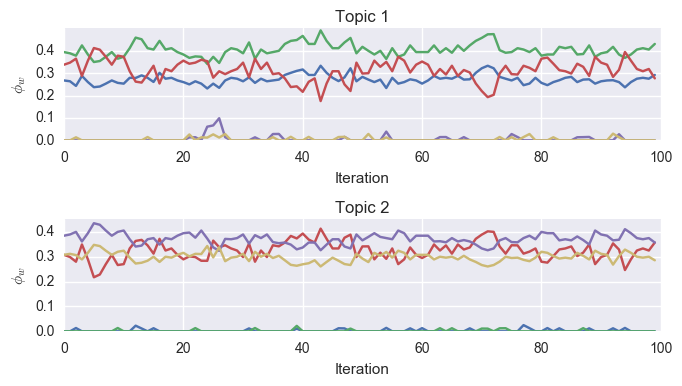

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axs = plt.subplots(T,1, sharey=False) # T row X 1 col


for t in range(T):
    for i in range(phi_T[t].shape[0]):
            axs[t].plot(phi_T[t][i,100:200]) # each word distribution over topic at i iteration
            axs[t].set_title('Topic '+ str(t+1))


fig.set_size_inches((7, 4)) # width, length
sns.despine()

for ax in axs:
    ax.set_ylabel(r'$\phi_w$')
    ax.set_xlabel('Iteration')
    ax.set_yticks(np.arange(0, 0.5, 0.1))
    
fig.tight_layout()
fig

Each panel shows the fluctaion a probability of assigning each word to topic j. 

Maybe later I am going to apply this conception using Database.
